# Predict response to stimuli: GRU for time series

In a *GRU timeseries* problem, we aim to predict the response of a stimuli, as a time series data. The input is a stimuli vs time and the output is response vs time curve. Depending on how we train the network the response curve could represent average response to the stimuli from different spatial locations or could represet response form a single spatial location. 

This notebook builds an GRU based model to predict the response to external stimuli. To do this, we'll provide the model with timeseries of stimuli and use the return sequences to return an output vector that has the same shape as that of the input time series, the output represents response to the stimuli.

In [110]:
import keras, tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imageio import imread
from IPython import display
from pathlib import Path
import os


In [111]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError ("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='same')
    return y

The input csv file contains N columns of response as tabular data, we load the data from disk and read it to a numpy array

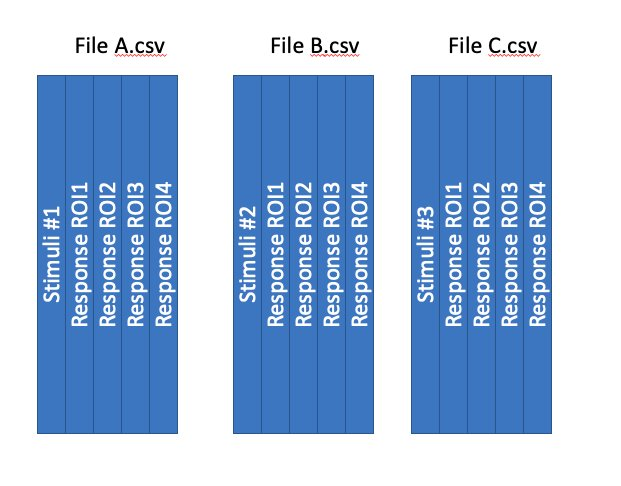

In [112]:
display.Image(filename='../images/data_style.jpg')

Model Name ROI1 Output data shape (9, 1408)
Model Name ROI2 Output data shape (9, 1408)
Model Name ROI3 Output data shape (9, 1408)
Model Name ROI4 Output data shape (9, 1408)
Model Name ROI5 Output data shape (9, 1408)
Model Name ROI6 Output data shape (9, 1408)
Model Name ROI7 Output data shape (9, 1408)
Model Name ROI8 Output data shape (9, 1408)
Model Name ROI9 Output data shape (9, 1408)
Model Name ROI10 Output data shape (9, 1408)
Input data shape (9, 1408, 1)


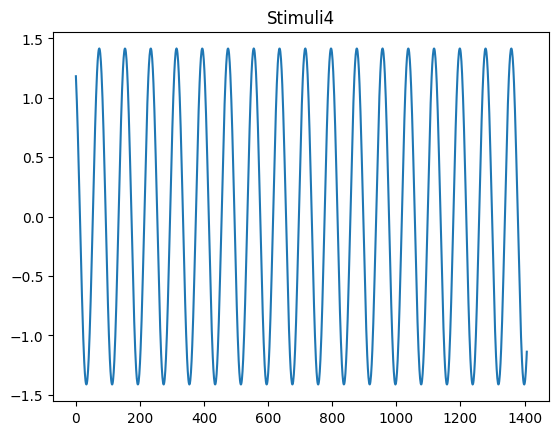

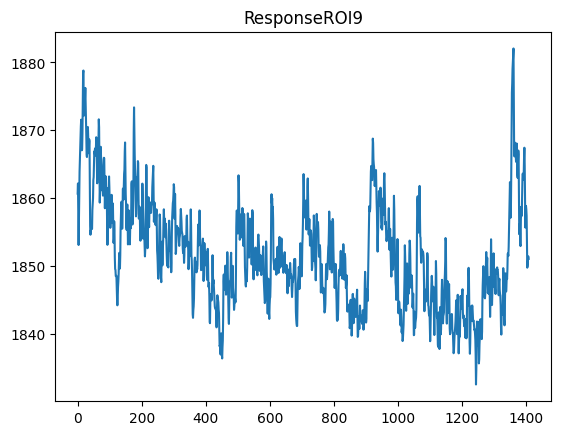

In [125]:
data_dir = Path('/home/ubuntu/stimuli_response/')
files = list(data_dir.glob('*.csv'))
stimuli = []
response_roi = []
response = {}
model_name = []
common_name = 'ROI'
sliding_window = 5
start = 128
end = 1536
for count, file in enumerate(files):
    
  stimuli_data = pd.read_csv(file, header=None)
  
  stimuli_data_tuple = stimuli_data.to_numpy()
  stimuli_data_array = np.asarray(stimuli_data_tuple)
  stimuli.append(stimuli_data_array[start:end,0])
  for i in range(1, stimuli_data_array.shape[1]):
    if common_name + str(i) in response.keys():
      response_list = response[common_name + str(i)]
      response_list.append(smooth(stimuli_data_array[:,i], window_len=sliding_window)[
        start:end]) 
    else:  
      response[common_name + str(i)] = [smooth(stimuli_data_array[:,i], window_len=sliding_window)[
        start:end]]
  
stimuli = np.asarray(stimuli)
stimuli = (stimuli - stimuli.mean()) / stimuli.std()
#This is our input data for training
stimuli = np.reshape(stimuli, (count + 1, end - start, 1 ) )
# Now we create a dictionary of the target whose key is the name of the model and value is the training label
for (k,v) in response.items():
    varr = np.asarray(v)
    response[k] = varr
    print('Model Name', k, 'Output data shape', varr.shape)
print('Input data shape', stimuli.shape)    

example_plot = 4
plt.plot(np.arange(stimuli.shape[1]), stimuli[example_plot,:,0])
plt.title('Stimuli'+  str(example_plot))
plt.show()
plt.plot(np.arange(stimuli.shape[1]),response[list(response.keys())[8]][example_plot,:])
plt.title('Response' + str(list(response.keys())[8]))
plt.show()

In [126]:
input_shape = (stimuli.shape[1],stimuli.shape[2])
units = 4
learning_rate = 0.01
epochs = 150
batch_size = 4
validation_split = 0.1

The dataset contains 4 colums of the stimuli and the first number represents the number of timepoints present in the data

GRU Unet

In [127]:
from keras import layers, models
from keras.layers import GRU, Conv1D, Dense, UpSampling1D, Bidirectional, Conv1D,Dropout,Concatenate, BatchNormalization, MaxPooling1D
inputs = layers.Input(shape = input_shape)
#First Layer
conv1 = GRU(units = units,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' ) (inputs)
conv1 = BatchNormalization()(conv1)
conv1 = GRU(units = units,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' ) (conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling1D(pool_size=2) (conv1)

#Second Layer

conv2 = GRU(units = units * 2,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = GRU(units = units * 2,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling1D(pool_size=2)(conv2)


#Third Layer

conv3 = GRU(units = units * 4,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = GRU(units = units * 4,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling1D(pool_size=2)(conv3)

#Fourth Layer

conv4 = GRU(units = units * 8,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = GRU(units = units * 8,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(conv4)
conv4 = BatchNormalization()(conv4)

#Dropout

drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling1D(pool_size=2)(drop4)


#Fifth Layer

conv5 = GRU(units = units * 16,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = GRU(units = units * 16,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(conv5)
conv5 = BatchNormalization()(conv5)
drop5 = Dropout(0.5)(conv5)

#Upsampling Layers

up6 = GRU(units = units * 8,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(UpSampling1D(size = 2)(drop5))
merge6 = Concatenate(axis=-1)([conv4,up6])
conv6 = GRU(units = units * 8,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(merge6)
conv6 = BatchNormalization()(conv6)
conv6 = GRU(units = units * 8,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(conv6)
conv6 = BatchNormalization()(conv6)

up7 = GRU(units = units * 4,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(UpSampling1D(size = 2)(conv6))
merge7 = Concatenate(axis=-1)([conv3,up7])
conv7 = GRU(units = units * 4,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(merge7)
conv7 = BatchNormalization()(conv7)
conv7 = GRU(units = units * 4,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(conv7)
conv7 = BatchNormalization()(conv7)

up8 = GRU(units = units * 2,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(UpSampling1D(size = 2)(conv7))
merge8 = Concatenate(axis=-1)([conv2,up8])
conv8 = GRU(units = units * 2,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(merge8)
conv8 = BatchNormalization()(conv8)
conv8 = GRU(units = units * 2,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(conv8)
conv8 = BatchNormalization()(conv8)

up9 = GRU(units = units,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(UpSampling1D(size = 2)(conv8))
merge9 = Concatenate(axis=-1)([conv1,up9])
conv9 = GRU(units = units,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(merge9)
conv9 = BatchNormalization()(conv9)
conv9 = GRU(units = units,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(conv9)
conv9 = BatchNormalization()(conv9)
conv9 = GRU(units = units,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(conv9)
conv9 = BatchNormalization()(conv9)
conv10 = GRU(units = 1,  activation = 'relu', return_sequences=True, kernel_initializer = 'he_normal' )(conv9)
outputs = conv10
model = models.Model(inputs, outputs)
opt = keras.optimizers.RMSprop(lr=learning_rate)

model.compile(loss='mse',
              optimizer=opt, metrics = ['mae'])
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 1408, 1)]    0           []                               
                                                                                                  
 gru_39 (GRU)                   (None, 1408, 4)      84          ['input_18[0][0]']               
                                                                                                  
 batch_normalization_124 (Batch  (None, 1408, 4)     16          ['gru_39[0][0]']                 
 Normalization)                                                                                   
                                                                                                  
 gru_40 (GRU)                   (None, 1408, 4)      120         ['batch_normalization_124[

                                                                                                  
 gru_51 (GRU)                   (None, 176, 32)      6336        ['batch_normalization_134[0][0]']
                                                                                                  
 batch_normalization_135 (Batch  (None, 176, 32)     128         ['gru_51[0][0]']                 
 Normalization)                                                                                   
                                                                                                  
 up_sampling1d_26 (UpSampling1D  (None, 352, 32)     0           ['batch_normalization_135[0][0]']
 )                                                                                                
                                                                                                  
 gru_52 (GRU)                   (None, 352, 16)      2400        ['up_sampling1d_26[0][0]']       
          

/home/ubuntu/anaconda3/envs/naparienv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Now let us plot the network graph using keras plot_model

<IPython.core.display.Image object>


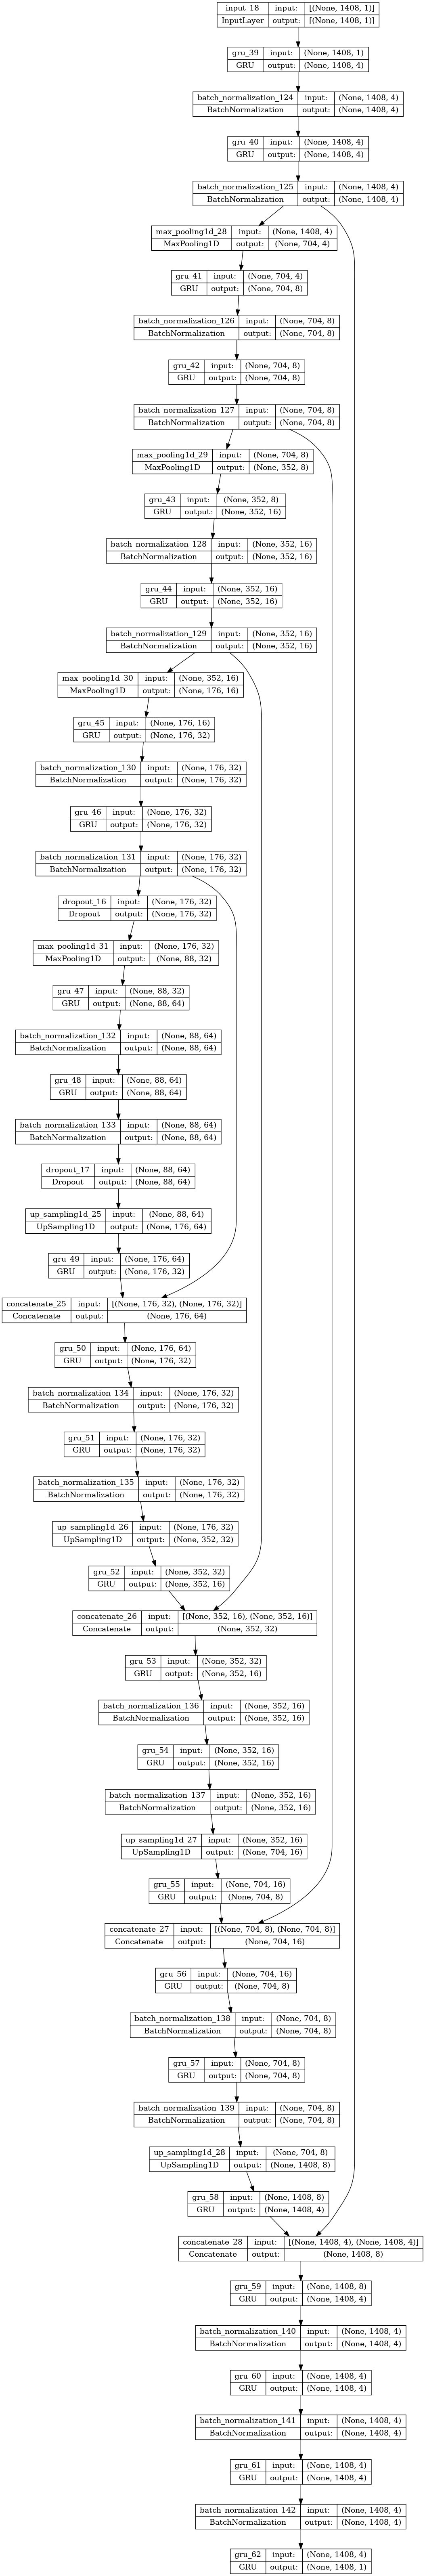

In [128]:
from keras.utils import plot_model

model_inline = plot_model(model, to_file = './model_time_series.png', 
show_shapes = True, show_layer_names=True)

print(model_inline)
model_inline

In [129]:
def plot_history(history):
  plt.figure()
  plt.plot(history.epoch, np.array(history.history['mae']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val loss')
  plt.legend()
  
  plt.show()

Now let us start the model training by first defining some parameters like epochs, validation_split, keras callbacks etc

In [ ]:
from keras import callbacks
for (k,v) in response.items():
        model_name = k 
        # Keras callbacks
        lrate = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=0)
        srate = callbacks.ModelCheckpoint(data_dir.as_posix() +  '/models/' + model_name + '.h5', monitor='loss', verbose=1,
                                          save_best_only=False, save_weights_only=False, mode='auto', period=1)
        history = model.fit(stimuli, v,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose = True,
                    validation_split= validation_split,
                    shuffle=True,
                               callbacks=[lrate, srate])
        plot_history(history) 
        

Epoch 1/150
2/2 [==============================] - ETA: 0s - loss: 4009659.5000 - mae: 2002.1069  
Epoch 1: saving model to /home/ubuntu/stimuli_response/models/ROI1.h5
2/2 [==============================] - 70s 8s/step - loss: 4009659.5000 - mae: 2002.1069 - val_loss: 4277663.5000 - val_mae: 2068.0154 - lr: 0.0100
Epoch 2/150
2/2 [==============================] - ETA: 0s - loss: 4008747.7500 - mae: 2001.8782
Epoch 2: saving model to /home/ubuntu/stimuli_response/models/ROI1.h5
2/2 [==============================] - 8s 5s/step - loss: 4008747.7500 - mae: 2001.8782 - val_loss: 4277319.5000 - val_mae: 2067.9324 - lr: 0.0100
Epoch 3/150
2/2 [==============================] - ETA: 0s - loss: 4007521.5000 - mae: 2001.5728
Epoch 3: saving model to /home/ubuntu/stimuli_response/models/ROI1.h5
2/2 [==============================] - 9s 5s/step - loss: 4007521.5000 - mae: 2001.5728 - val_loss: 4277459.0000 - val_mae: 2067.9661 - lr: 0.0100
Epoch 4/150
2/2 [==============================] - ETA:

Epoch 27/150
2/2 [==============================] - ETA: 0s - loss: 3845460.5000 - mae: 1960.3960
Epoch 27: saving model to /home/ubuntu/stimuli_response/models/ROI1.h5
2/2 [==============================] - 9s 5s/step - loss: 3845460.5000 - mae: 1960.3960 - val_loss: 4277974.0000 - val_mae: 2068.0906 - lr: 0.0100
Epoch 28/150
2/2 [==============================] - ETA: 0s - loss: 3724073.7500 - mae: 1929.0708
Epoch 28: saving model to /home/ubuntu/stimuli_response/models/ROI1.h5
2/2 [==============================] - 9s 5s/step - loss: 3724073.7500 - mae: 1929.0708 - val_loss: 4277972.5000 - val_mae: 2068.0901 - lr: 0.0100
Epoch 29/150
2/2 [==============================] - ETA: 0s - loss: 3647222.5000 - mae: 1908.3969
Epoch 29: saving model to /home/ubuntu/stimuli_response/models/ROI1.h5
2/2 [==============================] - 9s 5s/step - loss: 3647222.5000 - mae: 1908.3969 - val_loss: 4277958.0000 - val_mae: 2068.0867 - lr: 0.0100
Epoch 30/150
2/2 [==============================] - 

Epoch 53/150
2/2 [==============================] - ETA: 0s - loss: 2465014.0000 - mae: 1569.6147
Epoch 53: saving model to /home/ubuntu/stimuli_response/models/ROI1.h5
2/2 [==============================] - 8s 4s/step - loss: 2465014.0000 - mae: 1569.6147 - val_loss: 4122464.2500 - val_mae: 2030.1449 - lr: 0.0100
Epoch 54/150
2/2 [==============================] - ETA: 0s - loss: 2488188.0000 - mae: 1577.0220
Epoch 54: saving model to /home/ubuntu/stimuli_response/models/ROI1.h5
2/2 [==============================] - 9s 5s/step - loss: 2488188.0000 - mae: 1577.0220 - val_loss: 4110083.0000 - val_mae: 2027.0934 - lr: 0.0100
Epoch 55/150
2/2 [==============================] - ETA: 0s - loss: 2404721.7500 - mae: 1550.3403
Epoch 55: saving model to /home/ubuntu/stimuli_response/models/ROI1.h5
2/2 [==============================] - 9s 5s/step - loss: 2404721.7500 - mae: 1550.3403 - val_loss: 4099099.0000 - val_mae: 2024.3821 - lr: 0.0100
Epoch 56/150
2/2 [==============================] - 

Epoch 79/150
2/2 [==============================] - ETA: 0s - loss: 1628432.5000 - mae: 1275.4915
Epoch 79: saving model to /home/ubuntu/stimuli_response/models/ROI1.h5
2/2 [==============================] - 8s 4s/step - loss: 1628432.5000 - mae: 1275.4915 - val_loss: 3711828.2500 - val_mae: 1926.3574 - lr: 0.0100
Epoch 80/150
2/2 [==============================] - ETA: 0s - loss: 1587608.7500 - mae: 1259.4241
Epoch 80: saving model to /home/ubuntu/stimuli_response/models/ROI1.h5
2/2 [==============================] - 8s 5s/step - loss: 1587608.7500 - mae: 1259.4241 - val_loss: 3689683.7500 - val_mae: 1920.6008 - lr: 0.0100
Epoch 81/150
2/2 [==============================] - ETA: 0s - loss: 1535463.7500 - mae: 1238.6519
Epoch 81: saving model to /home/ubuntu/stimuli_response/models/ROI1.h5
2/2 [==============================] - 9s 5s/step - loss: 1535463.7500 - mae: 1238.6519 - val_loss: 3673169.5000 - val_mae: 1916.2969 - lr: 0.0100
Epoch 82/150
2/2 [==============================] - 

UNET usual but in 1D

In [ ]:
from keras import layers, models
from keras.layers import ConvGRU1D, GRU, Conv1D, Dense, UpSampling1D, Bidirectional, Conv1D,Dropout,Concatenate, BatchNormalization, MaxPooling1D
inputs = layers.Input(shape = input_shape)
#First Layer
conv1 = Conv1D(units, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal' ) (inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Conv1D(units, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal' ) (conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling1D(pool_size=2) (conv1)

#Second Layer

conv2 = Conv1D(units * 2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv1D(units * 2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling1D(pool_size=2)(conv2)


#Third Layer

conv3 = Conv1D(units * 4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv1D(units * 4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling1D(pool_size=2)(conv3)

#Fourth Layer

conv4 = Conv1D(units * 8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv1D(units * 8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
conv4 = BatchNormalization()(conv4)

#Dropout

drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling1D(pool_size=2)(drop4)


#Fifth Layer

conv5 = Conv1D(units * 16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv1D(units * 16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
conv5 = BatchNormalization()(conv5)
drop5 = Dropout(0.5)(conv5)

#Upsampling Layers

up6 = Conv1D(units * 8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(drop5))
merge6 = Concatenate(axis=-1)([conv4,up6])
conv6 = Conv1D(units * 8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv1D(units * 8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

up7 = Conv1D(units * 4 , 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv6))
merge7 = Concatenate(axis=-1)([conv3,up7])
conv7 = Conv1D(units * 4 , 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv1D(units * 4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

up8 = Conv1D(units  * 2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv7))
merge8 = Concatenate(axis=-1)([conv2,up8])
conv8 = Conv1D(units  * 2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv1D(units  * 2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

up9 = Conv1D(units, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv8))
merge9 = Concatenate(axis=-1)([conv1,up9])
conv9 = Conv1D(units, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv1D(units, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv1D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = BatchNormalization()(conv9)
conv10 = Conv1D(1, 1, activation = 'linear')(conv9)
outputs = conv10
model = models.Model(inputs, outputs)
opt = keras.optimizers.RMSprop(lr=learning_rate)

model.compile(loss='mse',
              optimizer=opt, metrics = ['mae'])
model.summary()